# Variational Inference with Bayesian Multivariate Gaussian Mixture Model

Coordinate ascent mean-field variational inference (CAVI) using the evidence lower bound (ELBO) to iteratively perform the optimal variational factor distribution parameter updates for clustering.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Helpers

In [2]:
def generate_data(std, k, n, dim=1):
    """ Generates data for mixture of Gaussians.
    
    Parameters
    ----------
    std : float
        Standard deviation of normal distributions.
    k : int
        Number of clusters.
    n : int
        Number of data points.
    dim : int
        The dimensionality of the data
    
    Returns
    -------
    numpy.ndarray
        The data, of shape (n, dim)
    categories : list
        The true category of each data point, of length n.
    means : numpy.ndarray
        The true means of each category, of shape (k, dim) 
    """
    # k means of dim dimension
    means = np.random.normal(0.0, std, size=(k, dim))
    data = []
    categories = []
    
    for i in range(n):
        # sample component assignment
        cat = np.random.choice(k)
        categories.append(cat)
        # sample data point from the Gaussian (multivariate)
        data.append(np.random.multivariate_normal(means[cat, :], np.eye(dim)))
    
    return np.stack(data), categories, means


def plot(x, y, c, means, title):
    plt.scatter(x, y, c=c)
    plt.scatter(means[:, 0], means[:, 1], c='r')
    plt.title(title)
    plt.savefig(f"{title}.png")
    plt.show()


def plot_elbo(elbo):
    plt.plot(elbo)
    plt.title('ELBO')
    plt.savefig("ELBO.png")
    plt.show()

## ELBO

In [3]:
def compute_elbo(data, psi, m, s2, sigma2, mu0):
    """ Computes the ELBO. The elbo terms are numbered elbo_i where i corresponds to the term number 
    in the report.
    
    Parameters
    ----------
    data : numpy.ndarray
        The data, of shape (n, dim)
    psi : numpy.ndarray
        Parameters of categorical posterior over mixture assignment.
        Of shape (n, k).
        Conjugate prior is Diriclet.
        np.sum(psi, axis=1) is all ones
    m : numpy.ndarray
        Mean parameters of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, p) where p is the dimesionality of the data.
        Conjugate prior is Gaussian.
    s2 : numpy.ndarray
        Variance (std squared) of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, 1) since clusters have diagonal covariance matrix, i.e.: all have same variance.
    sigma2 : numpy.ndarray
        Variance of the Gaussian of the prior mean per cluster.
        Of shape (), since it is a float
    m0 : numpy.ndarray
        Mean of the Gaussian of the prior mean per cluster.
        Of shape (p, ) where p is the dimensioanlity of the data.
        
    Returns
    -------
    elbo : float
        ELBO.
    """
    n, p = data.shape
    k = m.shape[0]

    elbo = 0

    # TODO: compute ELBO
    # expected log prior over mixture assignments
    elbo_2 = - n * np.log(k)

    # expected log prior over mixture locations
    elbo_1 = \
        -0.5 * (p * k * np.log(2*np.pi * sigma2))
    
    elbo_1_intermediate = 0
    
    for k_idx in range(k):
        elbo_1_intermediate += \
            p * s2[k_idx] + np.dot(m[k_idx].T, m[k_idx]) \
            - np.dot(m[k_idx].T, mu0) \
            - np.dot(mu0.T, m[k_idx]) \
            - np.dot(mu0.T, mu0)
    
    # -0.5 or +0.5?
    elbo_1 += -0.5 * sigma2**(-1) * elbo_1_intermediate
    
    # expected log likelihood
    
    # for diagonal covariance, lambda is set to 1
    lambda_ = 1.0
    
    elbo_3 = 0
    
    for n_idx in range(n):
        for k_idx in range(k):
            elbo_3 += \
                psi[n_idx, k_idx] * \
                (
                    -0.5 * p * np.log(2*np.pi*lambda_**2) \
                    -0.5 * lambda_**(-2) * \
                    (
                        np.dot(data[n_idx,:].T, data[n_idx,:]) \
                        - np.dot(data[n_idx,:].T, m[k_idx]) \
                        - np.dot(m[k_idx].T, data[n_idx,:]) \
                        + s2[k_idx] * p \
                        + np.dot(m[k_idx].T, m[k_idx])
                    ) 
                )

    # entropy of variational location posterior
    
    elbo_4 = 0
    
    for k_idx in range(k):
        elbo_4 += np.log(2*np.pi) + 2 * np.log(s2[k_idx]) + 1

    # entropy of the variational assignment posterior
    
    elbo_5 = 0
    
    for n_idx in range(n):
        for k_idx in range(k):
            elbo_5 -= psi[n_idx, k_idx] * np.log(psi[n_idx, k_idx])
    
    
    # sum up elbo
    elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5
    
    return elbo

## CAVI

In [4]:
def cavi(data, k, sigma2, m0, eps=1e-15):
    """ Coordinate ascent Variational Inference for Bayesian Mixture of Gaussians
    
    Parameters
    ----------
    data : numpy.ndarray
        The data, of shape (n, dim)
    k : int
        Number of clusters.
    sigma2 : numpy.ndarray
        Variance of the Gaussian of the prior mean per cluster.
        Of shape (), since it is a float
    m0 : numpy.ndarray
        Mean of the Gaussian of the prior mean per cluster.
        Of shape (p, ) where p is the dimensioanlity of the data.
    eps : float
        Convergence criterion.
        
    Returns
    -------
    m : numpy.ndarray
        Mean parameters of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, p) where p is the dimesionality of the data.
        Conjugate prior is Gaussian.
    s2 : numpy.ndarray
        Variance (std squared) of the Gaussian posterior over each component’s mean parameter.
        Of shape (k, 1) since clusters have diagonal covariance matrix, i.e.: all have same variance.
    psi : numpy.ndarray
        Parameters of categorical posterior over mixture assignment.
        Of shape (n, k).
        Conjugate prior is Diriclet.
        np.sum(psi, axis=1) is all ones
    elbo : float
        ELBO.
    """
    n, p = data.shape
    # initialize randomly
    m = np.random.normal(0., 1., size=(k, p))
    s2 = np.square(np.random.normal(0., 1., size=(k, 1)))
    psi = np.random.dirichlet(np.ones(k), size=n)

    # compute ELBO
    elbo = [compute_elbo(data, psi, m, s2, sigma2, m0)]
    convergence = 1.
    # for diagonal covariance, lambda is set to 1
    lambda_ = 1.0
    
    while convergence > eps:  # while ELBO not converged
        
        # update categorical
        for n_idx in range(n):
            for k_idx in range(k):
                psi[n_idx, k_idx] = \
                    np.exp(
                        np.dot(data[n_idx].T, m[k_idx]) * lambda_**(-2) \
                        - 0.5 * lambda_**(-2) * (np.dot(m[k_idx].T, m[k_idx]) + p*s2[k_idx])
                    )
            psi[n_idx] /= np.sum(psi[n_idx])
        
        # update posterior parameters for the component means
        for k_idx in range(k):
            for n_idx in range(n):
                s2[k_idx] += lambda_**(-2) * psi[n_idx, k_idx]
            
            s2[k_idx] += sigma2**(-2)
            s2[k_idx] = s2[k_idx]**(-1)
        
        for k_idx in range(k):
            for n_idx in range(n):
                m[k_idx] += psi[n_idx, k_idx] * data[n_idx]
            m[k_idx] *= lambda_**(-2)
            m[k_idx] += m0 / sigma2
            m[k_idx] *= s2[k_idx]
        
        # compute ELBO
        elbo.append(compute_elbo(data, psi, m, s2, sigma2, m0))
        convergence = elbo[-1] - elbo[-2]

    return m, s2, psi, elbo

## Run

No seed is used to get varying results.

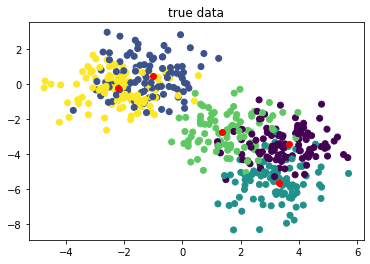

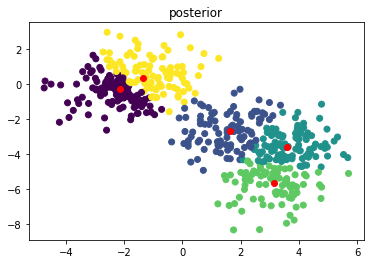

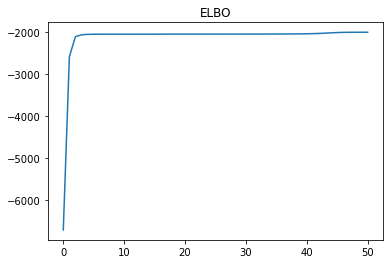

In [5]:
# parameters
p = 2
k = 5
sigma = 5.

data, categories, means = generate_data(std=sigma, k=k, n=500, dim=p)

m = list()
s2 = list()
psi = list()
elbo = list()
best_i = 0

for i in range(10):
    
    m_i, s2_i, psi_i, elbo_i = cavi(data, k=k, sigma2=sigma, m0=np.zeros(p))
    m.append(m_i)
    s2.append(s2_i)
    psi.append(psi_i)
    elbo.append(elbo_i)
    
    if i > 0 and elbo[-1][-1] > elbo[best_i][-1]:
        best_i = i

class_pred = np.argmax(psi[best_i], axis=1)
plot(data[:, 0], data[:, 1], categories, means, title='true data')
plot(data[:, 0], data[:, 1], class_pred, m[best_i], title='posterior')
plot_elbo(elbo[best_i])